# MNIST Revisited
Going back to the MNIST handwritten digit competition, this time in Jupyter with some new ideas.

Notes:
- Use PCA to visualize digit distribution (2D)
- Use PCA to speed up training
    - Maintain 99% of variance

Other:
- Only include meaningful comments

## Load and Preprocess Data

In [32]:
# ALL imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style; style.use('ggplot')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# setup features and labels as np arrays
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [5]:
X.shape, y.shape

((42000, 784), (42000,))

In [6]:
np.min(X), np.max(X)

(0, 255)

In [7]:
# scale feature values to be in range 0 -> 1 (important for neural network classifier)
X = X / 255

In [8]:
np.min(X), np.max(X)

(0.0, 1.0)

In [9]:
# save 1D labels
y_old = y

# one hot encode labels: create 10-element array for each label (necessary for training)
ohe = OneHotEncoder(categories='auto')
y = ohe.fit_transform(y.reshape(-1, 1)).toarray()

In [10]:
np.where(y[:4] == 1)

(array([0, 1, 2, 3]), array([1, 0, 1, 4]))

In [11]:
# count the number of each digit in the dataset
print('Digit\tCount')

for i in range(10):
    print(i, '\t', np.count_nonzero(y[:, i]))

Digit	Count
0 	 4132
1 	 4684
2 	 4177
3 	 4351
4 	 4072
5 	 3795
6 	 4137
7 	 4401
8 	 4063
9 	 4188


In [12]:
np.count_nonzero(y)

42000

## PCA for Visualization

In [13]:
# pca to 2D
pca = PCA(n_components=2)
X_red = pca.fit_transform(X)

In [14]:
X_red

array([[-2.59449694, -2.74225779],
       [ 6.67235025, -1.4139151 ],
       [-3.47801972, -1.15192942],
       ...,
       [ 1.3187007 ,  3.72555447],
       [ 1.28391907,  0.24313802],
       [-1.42843351,  1.642695  ]])

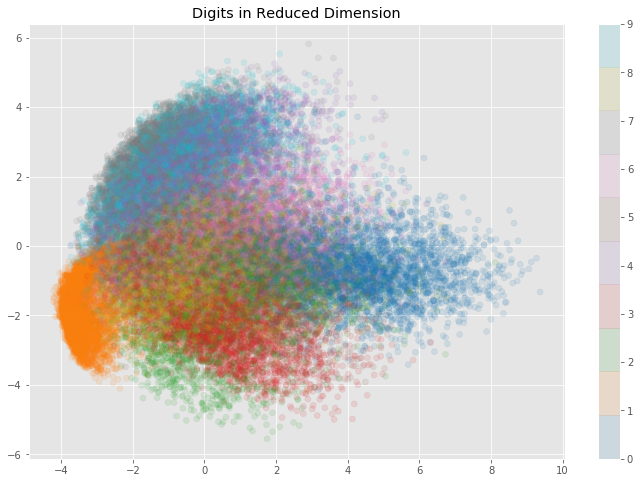

In [15]:
plt.rcParams['figure.figsize'] = [12, 8]

# plot light digits with labels represented by color
plt.scatter(X_red[:, 0], X_red[:, 1], c=y_old, alpha=0.125, cmap='tab10')
plt.colorbar()
plt.title('Digits in Reduced Dimension');

In [16]:
# make list of mean reduced features for digits
mean_ls = []

for i in range(10):
    mean_ls.append([np.mean(X_red[y_old == i][:, 0]), np.mean(X_red[y_old == i][:, 1])])
    
mean_arr = np.asarray(mean_ls)

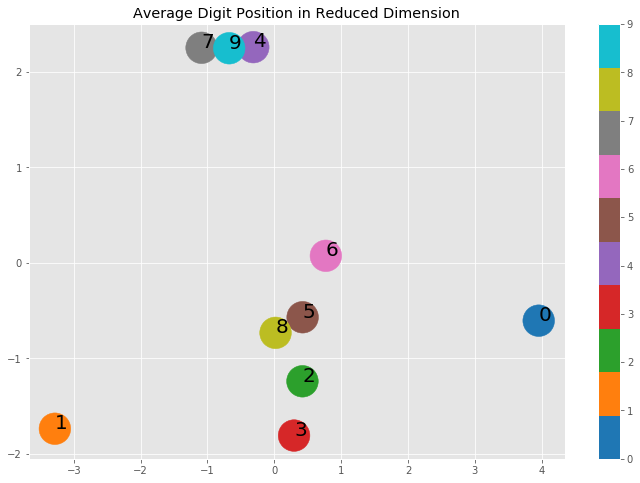

In [17]:
# plot mean values with annotations
plt.scatter(mean_arr[:, 0], mean_arr[:, 1], 
            c=range(10), 
            cmap='tab10',
            s=1000)

plt.colorbar()

for i in range(10):
    plt.annotate(i, (mean_arr[i, 0], mean_arr[i, 1]), fontsize=20,)

plt.title('Average Digit Position in Reduced Dimension');

## PCA to Improve Training Speed

In [18]:
# Use built-in functionality to choose dimension which preserves 99% of variance
pca = PCA(n_components=0.99, svd_solver='full')
X = pca.fit_transform(X)
np.sum(pca.explained_variance_ratio_), X.shape[1]

(0.9900828214754722, 331)

PCA reduces the number of features by a factor greater than 2, while still retaining 99% of the variance in the original dataset!

## Build Neural Network Model

In [57]:
# train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y_old, test_size=0.2, shuffle=True)

I will use a common neural network architecture -- one hidden layer, with the number of nodes between the number in the input and output layers.

This architecture consistently outperformed deeper networks in my testing.

In [58]:
# neural network
nn = MLPClassifier(hidden_layer_sizes=(170,), max_iter=1000)
nn.fit(X_train, y_train)
accuracy_score(y_val, nn.predict(X_val))

0.9716666666666667

The network classifies digits in the validation set with a 97% accuracy. Let's see how it does on the test set!